# Shamir Secret Sharing

Shamir secret sharing is a $(t+1)$-out-of-$n$ secret sharing protocol. Given a secret value $s$, 
- define $f(X) = f_t X^t + \ldots + f_1 X + s$, where $f_t, \ldots, f_1 \leftarrow \mathbb{F}_p$ for some prime $p > n$
- give share $f(i)$ to $P_i$ ($i = 1, \ldots, n$)

To reconstruct, at least $t+1$ parties pool their points $(i, f(i))$ and reconstruct the polynomial $f$, e.g. as 

$$ \sum_i^{t+1} \ell_i \cdot f(i), \text{ where } \ell_i(X) = \frac{\Pi_{j \neq i} (X-x_j)}{\Pi_{j \neq i} (x_i-x_j)} $$ 

Then, evaluate $f(0) = s$.

In [1]:
import numpy as np
import random, sympy
import matplotlib.pyplot as plt

First, let's define some helper functions for dealing with polynomials.

In [152]:
def term_to_string(coeff, deg):
    if coeff == 0:
        return ""

    temp = "{}".format(coeff)
    app = ""
    # constant term
    if deg == 0:
        return temp
    # x term
    elif deg == 1:
        app = "x"
    # others
    else:
        app = "x^{}".format(deg)
    return app if coeff == 1 else temp+app

def print_poly(coeffs):
    poly_str = ""
    
    # coefficients from highest to lowest degree
    deg = len(coeffs)-1
    for i in range(len(coeffs)):
        if(coeffs[i]!=0):
            poly_str += "{} + ".format(term_to_string(coeffs[i], deg-i))
    
    # remove extra + at end
    print(poly_str[:-3])
    
def eval_poly(coeffs, x):
    # coefficients from highest to lowest degree
    deg = len(coeffs)-1
    ans = 0
    for i in range(len(coeffs)):
        ans += coeffs[i]*x**(deg-i)
        
    # in real SSS, this is over a finite field (mod p)
    # return ans%p
    
    # but this is not representable in 2D so we will use int arith
    # (note this is not secure)
    return ans

## Share
Here is our sharing function:

In [153]:
def share(s, n, t, p):
    # check p
    if not sympy.isprime(p):
        print("p={} is not prime!".format(p))
        return
    if p <= n:
        print("p={} must be greater than n={}".format(p, n))
        return
        
    # check t
    if t >= n:
        print("t={} must be less than n={}".format(t, n))
        return

    # check s is in field
    if p <= s:
        print("s={} must be less than p={}".format(s, p))
        return
        
    coeffs = []
    for i in range(t):
        # sample coefficients from F_p = {0, ..., p-1}
        coeffs.append(random.randint(0,p-1))
    # secret is the y-intercept
    coeffs.append(s)
    
    shares = []
    for i in range(1,n+1):
        shares.append((i, eval_poly(coeffs, i)))
        
    # plot the polynomial
    print("The random degree t={} polynomial is".format(t))
    print_poly(coeffs)
    x = np.linspace(0, n, n+1)
    y = [eval_poly(coeffs, i) for i in x]
    plt.plot(x, y)
    
    # plot the shares
    print()
    print("The shares are points on that polynomial:")
    print(shares)
    x1 = [shares[i][0] for i in range(len(shares))]
    y1 = [shares[i][1] for i in range(len(shares))]
    plt.scatter(x1, y1)
    
    # plot the secret
    plt.scatter(0, s)
    
    print()
    print("Here is a visual representation (secret in orange).")
        
    return shares

For example, say our secret is the number 42. We'd like to share it among 10 parties (n=10), and we'll allow any 4 of those to recover the secret (t=3, t+1 can recover). Now let's pick a prime number p that's bigger than both the secret and the number of parties (so, p>42). The next largest prime is 43, so let's try that!

How would you call the `share` function with these parameters?

**Answer**
```
shares = share(42, 10, 3, 43)
```

The random degree t=3 polynomial is
15x^3 + 4x^2 + 11x + 42

The shares are points on that polynomial:
[(1, 72), (2, 200), (3, 516), (4, 1110), (5, 2072), (6, 3492), (7, 5460), (8, 8066), (9, 11400), (10, 15552)]

Here is a visual representation (secret in orange).


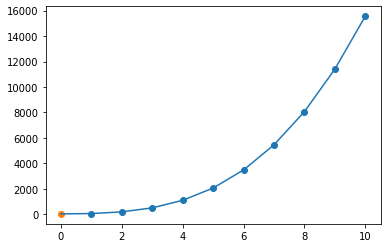

In [154]:
shares = share(42, n=10, t=3, p=43)

Now we can distribute these points among our 10 parties!

## Reconstruct
Say 4 of those parties (Alice, Bob, Charlie, and Diane) want to recover the secret. We set $t=3$, so they should be able to do this (remember, a minimum of $t+1$ parties is needed). Together, they hold 4 points on the degree-3 polynomial, which uniquely defines it! They can pool this information to recover the polynomial $f$ and evaluate it at $x=0$ using the `recon` function:

In [149]:
def recon(shares, n, t):
    if len(shares) < t+1:
        print("Not enough shares to reconstruct! ({} < t+1={})".format(len(shares), t+1))
        return
    
    # i Lagrange basis polynomials evaluated at 0
    ell = [1]*len(shares)
    for i in range(len(shares)):
        #ell[i] = 1
        for j in range(len(shares)):
            if i!=j:
                ell[i] *= float(0-shares[j][0])/(shares[i][0]-shares[j][0])
    
    # interpolate
    # f(X) = sum_1^{t+1} ell_i(X) * y_i
    # s = f(0)
    s = 0
    for i in range(len(shares)):
        s += ell[i]*shares[i][1]

    print("The reconstructed secret is:")
    return int(s)

Assuming Alice, Bob, Charlie, and Diane have the points for $x=1,2,3,4$, respectively, can you use the shares of 42 we created earlier to recover the secret?

**Answer**
```
recon(shares[:4], n=10, t=3)
```

In [150]:
recon(shares, n=10, t=3)

The reconstructed secret is:


42